[View in Colaboratory](https://colab.research.google.com/github/davidkant/mai/blob/master/7_1_The_Speaking_Piano.ipynb)

# 7.1 The Speaking Piano
Generally put, ***machine listening*** refers to algorithms that extract from sound the same kinds of musical information that humans do. This may include separating melody from accompaniment, identifying rhythms, finding the tempo or beat, recognizing genre, mood, and musical forms, identifying specific sounds or musical instruments, or segmenting music into structures such as verse and chorus. In this notebook, we'll start with pitch and loudness, since they are fundemantal features to many (but not all!) musical systems. Let's see if we can make something like Peter Ablinger's [*Speaking Piano*](https://www.youtube.com/watch?v=muCPjK4nGY4). We'll use machine listening to translate audio of human speech into musical notes and see what it sounds like!

# Setup

In [0]:
# install external libraries
!pip install -q git+https://github.com/davidkant/mai#egg=mai;
!pip install -q pretty_midi
!pip install -q pyfluidsynth
!pip install librosa
!pip install essentia
!apt-get -qq update
!apt-get -qq install -y libfluidsynth1
!git clone https://github.com/davidkant/mai.git

In [0]:
# imports
import mai
import librosa
from librosa import display
import essentia
from essentia import standard
import pretty_midi
import numpy as np
import IPython.display as ipyd
import matplotlib.pyplot as plt

# Load a soundfile
Load a soundfile to work with — but don't listen to it just yet! The audio data is stored in the variable `y`. This audiofile comes from the Symbolic Sound's Kyma system, so look there if you find yourself wondering what is a cephalaphadge...

In [0]:
filename = 'mai/resources/audio/alienthreat.wav'
y, sr = librosa.load(filename, sr=None)

Plot the waveform.

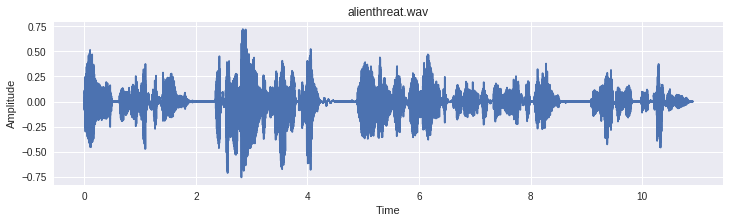

In [123]:
plt.figure(figsize=(12,3))
plt.plot(np.arange(len(y))/float(sr), y)
plt.title('alienthreat.wav')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Pitch Estimation
 
Let's convert the audiofile into a sequence of pitches. Since the audiofile is rather long, we don't want to represent it with just one note, but with a sequence of notes. To do this, we step through the audiofile one tiny slice at a time, and analyze the pitch of each slice. These slices are called ***frames*** and there are a few parameters to be aware of:

* `frame_length` is the size (in samples) of each slice is
* `hop_length` is the distance we slide over from frame to frame

In [0]:
# frame parameters
frame_length = 2048
hop_length = 512

The function `mai.listen.ypitch()` steps through the audio one frame at a time and returns a sequence of pitches. It also returns a confidence score for each frame, which expresses how certain the estimation is.

In [0]:
# pitch estimation
pitches, confidences = mai.listen.ypitch(y, frame_length=frame_length, hop_length=hop_length)

# convert frequency in Hz to MIDI number
pitches = [mai.musifuncs.hz_to_midi(p) for p in pitches]

Plot pitches and confidences.

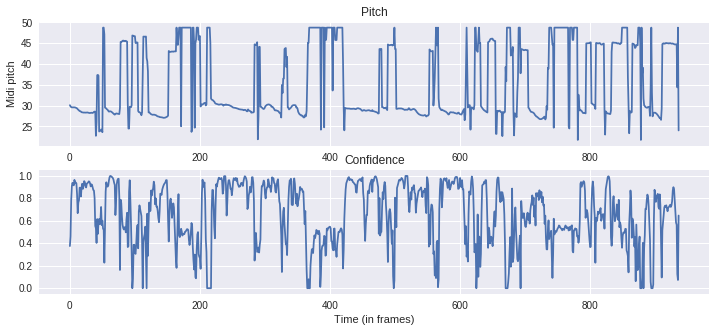

In [126]:
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.plot(librosa.hz_to_midi(pitches))
plt.title('Pitch')
plt.ylabel('Midi pitch')
plt.subplot(2,1,2)
plt.plot(confidences)
plt.title('Confidence')
plt.xlabel('Time (in frames)')
plt.show()

Convert to MIDI piano and let's hear it.

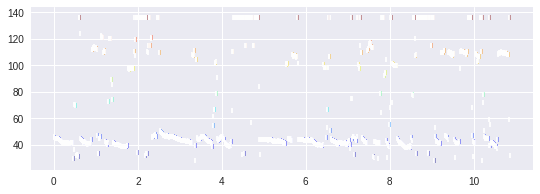

In [127]:
# plot music and listen
mai.make_music_plot(pitches, durs=float(hop_length)/sr)
mai.make_music(pitches, durs=float(hop_length)/sr, format='inbrowser')

Is the piano speaking yet? Do you hear the cephalaphadge?

# Many Many Notes
Perhaps more notes would help. Instead of estimating *one* note per slice, let's estimate *multiple* notes per slice — like a chord! In the cell below, `num_peaks` determines the number of notes per slice. We'll start with `3`.

In [0]:
# parameters
hop_length = 512
num_peaks = 3

# pitch estimation
pitches, h, D, peaks, confidences, t = mai.listen.ppitch(y, 
    sr=sr, n_fft=2048, win_length=2048, hop_length=hop_length, num_peaks=num_peaks, 
    num_pitches=3, min_fund=60, max_fund=2000, max_peak=20000, npartial=4, 
    ml_width=50, bounce_width=50)

Plot them. Each of the three tracks is shows in a different color.

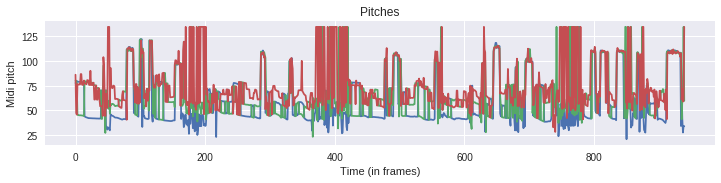

In [129]:
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.plot(librosa.hz_to_midi(peaks))
plt.title('Pitches')
plt.ylabel('Midi pitch')
plt.xlabel('Time (in frames)')
plt.show()

And listen. We have to do a little bit of pre-processing to convert the data to a form `mai.make_music()` can play.

In [130]:
# pre-processing for mai.make_music (don't worry about the code here)
pitches_list = [list(frame) for frame in peaks]
unravel = reduce(lambda x,y: x+y, pitches_list)
unravel = [librosa.hz_to_midi(x) for x in unravel]
durs = ([0]*(num_peaks-1) + [float(hop_length)/sr])*len(pitches_list[0:])

# convert to MIDI and listen
mai.make_music(unravel, durs=durs, format='inbrowser')

We're starting to hear it, yes? Go back and increase `num_peaks` to 10. Now you should really hear it...

# What happened?!

Hopefully you're hearing the piano speak. Why? We can think of sound as being composed of many different frequencies, not just the one key you press on the piano keyboard — Don't believe me? Go hammer away on a single piano key, and if you listen closely, you'll hear higher frequencies ringing as well... Moreover,  the relative loudness of all of these different frequencies is what gives each sound its identity. It's what makes a piano sound different from a saxphone and from a human voice. In the case of the speaking piano, the pitch analysis is capturing many of these higher frequencies and reproducing them on the piano. As we capture more and more, the quality of human speech becomes audible. 